# **DATA GENERATION**

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2 as cv
from glob import glob
from tqdm import tqdm
from albumentations import HorizontalFlip, VerticalFlip
train_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')

X = train_df['id_code']
y = train_df['diagnosis']

print("Done")

Done


## Data Augmentation
## Image Augmentation

In [3]:
import cv2
import numpy as np
import os

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
def preprocessimage(image_path, save_path):
    target_size = (256,256)
    my_image = cv2.imread(image_path)
    img = os.path.split(image_path)[-1]
    img_1 = img.split('.')[0]+"_1."+img.split('.')[1]
    
    my_image = cv2.resize(my_image, target_size)
    my_image = cv2.cvtColor(my_image, cv2.COLOR_BGR2GRAY)
    
    my_image_1 =cv2.flip(my_image,1) 
    create_dir(save_path)
    new_image_path = os.path.join(save_path, img)    
    cv2.imwrite(new_image_path, my_image)
    new_image_path = os.path.join(save_path, img_1)
    cv2.imwrite(new_image_path, my_image_1)

print("over")

over


In [4]:
from tqdm import tqdm
import numpy as np

for x in tqdm(X, desc='Processing Training Images', unit='image'):
    preprocessimage(f'/kaggle/input/aptos2019-blindness-detection/train_images/{x}.png', '/kaggle/working/Preprocessed/Data')
    

Processing Training Images: 100%|██████████| 3662/3662 [06:52<00:00,  8.87image/s]


## Label Augmentation

In [5]:
df = X.copy()
for x in df:
    x =x+"_1"
X = pd.concat([X, df], ignore_index=True)
y = pd.concat([y,y], ignore_index=True)

## Train-Test Split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
Train_df = pd.concat([X_train,y_train] , axis=1)
Test_df = pd.concat([X_val,y_val] , axis=1)

In [9]:
Train_df['id_code'] = Train_df['id_code'].astype(str) + '.png'
Test_df['id_code'] = Test_df['id_code'].astype(str) + '.png'

# DATASET GENERATION

In [12]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Train_df['diagnosis'] = Train_df['diagnosis'].astype(str)  # Ensure values are strings
Test_df['diagnosis'] = Test_df['diagnosis'].astype(str)


datagen=ImageDataGenerator(
    rescale=1./255,
)

batch_size = 4
image_size = 256



train_gen=datagen.flow_from_dataframe(
    dataframe=Train_df,
    directory="/kaggle/working/Preprocessed/Data",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    target_size=(image_size,image_size),
    color_mode ="grayscale" 
    
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,image_size, image_size, 1], [None,5]) 
)

# Repeat the dataset indefinitely
total_steps_per_epoch =len(train_gen)//batch_size
train_dataset = train_dataset.repeat(total_steps_per_epoch).prefetch(buffer_size=tf.data.AUTOTUNE)

test_gen=datagen.flow_from_dataframe(
    dataframe=Test_df,
    directory="/kaggle/working/Preprocessed/Data",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    target_size=(image_size,image_size),
    color_mode ="grayscale")

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_gen,
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,image_size, image_size, 1], [None,5]) 
)
test_dataset = test_dataset.repeat(total_steps_per_epoch).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 5126 validated image filenames belonging to 5 classes.
Found 2198 validated image filenames belonging to 5 classes.


# MODEL

In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Activation, MaxPool2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(x, filters):
    x = conv_block(x, filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(x, skip_features, filters):
    x = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)  # Downsampling part

    # Bottleneck
    b1 = Conv2D(1024, 3, activation='relu', padding='same')(p3)
    b1 = Conv2D(1024, 3, activation='relu', padding='same')(b1)

    # Decoder
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)  # Upsampling part

    # Output of U-Net
    conv_out = Conv2D(1, 1, padding="same", activation="relu")(d3)

    # Flatten and Dense layers
    x = Flatten()(conv_out)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(5, activation='softmax')(x)  # Assuming classification task

    # Define model
    model = Model(inputs, x, name="1-Stack-UNET")
    return model
model=build_unet((256,256,1))
model.summary()

Model: "1-Stack-UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 256, 256, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_12 (Ba  (None, 256, 256, 64)         256       ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_12 (Activation)  (None, 256, 256, 64)         0         ['batch_normalizati

 tchNormalization)                                                                                
                                                                                                  
 activation_19 (Activation)  (None, 64, 64, 256)          0         ['batch_normalization_19[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_transpose_4 (Conv2D  (None, 128, 128, 128)        131200    ['activation_19[0][0]']       
 Transpose)                                                                                       
                                                                                                  
 concatenate_4 (Concatenate  (None, 128, 128, 256)        0         ['conv2d_transpose_4[0][0]',  
 )                                                                   'activation_15[0][0]']       
          

## GPU Configuration

In [13]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 2


## Model Definition

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

with strategy.scope():
    optimizer = Adam(learning_rate=0.0001, amsgrad=True, epsilon=1e-6)
    model = build_unet((256, 256, 1))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=[
            'accuracy',
            Precision(),
            Recall(),
            AUC(name='auc')
        ]
    )


In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', patience=20, mode='max')
mc = ModelCheckpoint('model.keras', monitor='val_loss',mode='min' ,save_best_only=True )

# MODEL TRAINING

In [16]:
steps_per_epoch = len(Train_df) // batch_size
history = model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_dataset,
          validation_steps=len(y_train) //batch_size,
          epochs=15,
          callbacks = [es, mc],
          verbose=1)

Epoch 1/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 384s 259ms/step - accuracy: 0.6637 - auc: 0.8874 - loss: 0.9768 - precision: 0.8100 - recall: 0.5139 - val_accuracy: 0.7305 - val_auc: 0.9320 - val_loss: 0.7495 - val_precision: 0.8957 - val_recall: 0.5734
Epoch 2/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 331s 256ms/step - accuracy: 0.7346 - auc: 0.9260 - loss: 0.7667 - precision: 0.8407 - recall: 0.6083 - val_accuracy: 0.7582 - val_auc: 0.9428 - val_loss: 0.6761 - val_precision: 0.8549 - val_recall: 0.6512
Epoch 3/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 327s 255ms/step - accuracy: 0.7711 - auc: 0.9444 - loss: 0.6617 - precision: 0.8527 - recall: 0.6819 - val_accuracy: 0.7707 - val_auc: 0.9475 - val_loss: 0.6407 - val_precision: 0.8549 - val_recall: 0.6812
Epoch 4/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 327s 256ms/step - accuracy: 0.8578 - auc: 0.9756 - loss: 0.4225 - precision: 0.9027 - recall: 0.8112 - val_accuracy: 0.8394 - val_auc: 0.9683 - val_loss: 0.4910 - val_precision: 0.8698 - val_recall: 0.7960
Epoch 5/

In [20]:
steps_per_epoch = len(Train_df) // batch_size
history1 = model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_dataset,
          validation_steps=len(y_train) //batch_size,
          epochs=15,
          callbacks = [es, mc],
          verbose=1)

Epoch 1/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 324s 253ms/step - accuracy: 0.9888 - auc: 0.9989 - loss: 0.0356 - precision: 0.9893 - recall: 0.9888 - val_accuracy: 0.9238 - val_auc: 0.9880 - val_loss: 0.3048 - val_precision: 0.9282 - val_recall: 0.9140
Epoch 2/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 327s 255ms/step - accuracy: 0.9898 - auc: 0.9999 - loss: 0.0255 - precision: 0.9900 - recall: 0.9898 - val_accuracy: 0.9207 - val_auc: 0.9874 - val_loss: 0.2920 - val_precision: 0.9299 - val_recall: 0.9121
Epoch 3/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 327s 255ms/step - accuracy: 0.9887 - auc: 0.9994 - loss: 0.0295 - precision: 0.9893 - recall: 0.9885 - val_accuracy: 0.9258 - val_auc: 0.9858 - val_loss: 0.2890 - val_precision: 0.9324 - val_recall: 0.9207
Epoch 4/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 327s 256ms/step - accuracy: 0.9879 - auc: 0.9999 - loss: 0.0273 - precision: 0.9879 - recall: 0.9875 - val_accuracy: 0.9187 - val_auc: 0.9884 - val_loss: 0.2719 - val_precision: 0.9286 - val_recall: 0.9101
Epoch 5/

In [29]:
steps_per_epoch = len(Train_df) // batch_size
history1 = model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_dataset,
          validation_steps=len(y_train) //batch_size,
          epochs=15,
          callbacks = [es, mc],
          verbose=1)

Epoch 1/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 325s 254ms/step - accuracy: 0.9877 - auc: 0.9999 - loss: 0.0223 - precision: 0.9884 - recall: 0.9876 - val_accuracy: 0.9218 - val_auc: 0.9866 - val_loss: 0.3109 - val_precision: 0.9280 - val_recall: 0.9172
Epoch 2/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 324s 253ms/step - accuracy: 0.9899 - auc: 0.9999 - loss: 0.0213 - precision: 0.9903 - recall: 0.9899 - val_accuracy: 0.9195 - val_auc: 0.9848 - val_loss: 0.3312 - val_precision: 0.9243 - val_recall: 0.9164
Epoch 3/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 325s 254ms/step - accuracy: 0.9864 - auc: 0.9999 - loss: 0.0214 - precision: 0.9864 - recall: 0.9861 - val_accuracy: 0.9227 - val_auc: 0.9866 - val_loss: 0.3047 - val_precision: 0.9266 - val_recall: 0.9125
Epoch 4/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 326s 254ms/step - accuracy: 0.9903 - auc: 1.0000 - loss: 0.0185 - precision: 0.9904 - recall: 0.9902 - val_accuracy: 0.9242 - val_auc: 0.9875 - val_loss: 0.2944 - val_precision: 0.9315 - val_recall: 0.9191
Epoch 5/

In [35]:
steps_per_epoch = len(Train_df) // batch_size
history1 = model.fit(train_dataset,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_dataset,
          validation_steps=len(y_train) //batch_size,
          epochs=15,
          callbacks = [es, mc],
          verbose=1)

Epoch 1/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 325s 254ms/step - accuracy: 0.9883 - auc: 0.9999 - loss: 0.0181 - precision: 0.9884 - recall: 0.9879 - val_accuracy: 0.9265 - val_auc: 0.9861 - val_loss: 0.3012 - val_precision: 0.9325 - val_recall: 0.9226
Epoch 2/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 325s 254ms/step - accuracy: 0.9915 - auc: 1.0000 - loss: 0.0150 - precision: 0.9925 - recall: 0.9914 - val_accuracy: 0.9246 - val_auc: 0.9866 - val_loss: 0.3127 - val_precision: 0.9275 - val_recall: 0.9199
Epoch 3/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 325s 253ms/step - accuracy: 0.9880 - auc: 0.9999 - loss: 0.0223 - precision: 0.9882 - recall: 0.9878 - val_accuracy: 0.9230 - val_auc: 0.9862 - val_loss: 0.3194 - val_precision: 0.9316 - val_recall: 0.9156
Epoch 4/15
1281/1281 ━━━━━━━━━━━━━━━━━━━━ 324s 253ms/step - accuracy: 0.9864 - auc: 0.9999 - loss: 0.0227 - precision: 0.9875 - recall: 0.9863 - val_accuracy: 0.9261 - val_auc: 0.9868 - val_loss: 0.3234 - val_precision: 0.9328 - val_recall: 0.9172
Epoch 5/

KeyboardInterrupt: 

# METRICS

In [36]:
import pandas as pd

history1_data = history1.history

df1 = pd.DataFrame(history1_data)

combined_df = pd.concat([combined_df, df1], ignore_index=True)
combined_df

,accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall
0,0.699454,0.903761,0.892075,0.823145,0.541374,0.730469,0.932029,0.749467,0.895668,0.573438
1,0.734088,0.932388,0.735191,0.845750,0.629442,0.758203,0.942757,0.676083,0.854872,0.651172
2,0.772745,0.944854,0.657095,0.849903,0.687622,0.770703,0.947546,0.640670,0.854902,0.681250
3,0.836392,0.970905,0.471717,0.880035,0.784850,0.839390,0.968322,0.490998,0.869769,0.796014
4,0.924639,0.988084,0.275928,0.940384,0.899258,0.880469,0.977802,0.404396,0.900328,0.857422
...,...,...,...,...,...,...,...,...,...,...
56,0.988676,0.999935,0.019433,0.988676,0.988676,0.925391,0.986803,0.310508,0.931102,0.923828
57,0.989848,0.999950,0.017464,0.990231,0.989457,0.918750,0.985745,0.317463,0.925662,0.914453
58,0.991410,0.999954,0.016766,0.991406,0.991019,0.928097,0.985934,0.306646,0.933783,0.920281
59,0.990629,0.999949,0.017819,0.990629,0.990629,0.923437,0.986384,0.311240,0.930912,0.921094


## Accuracy

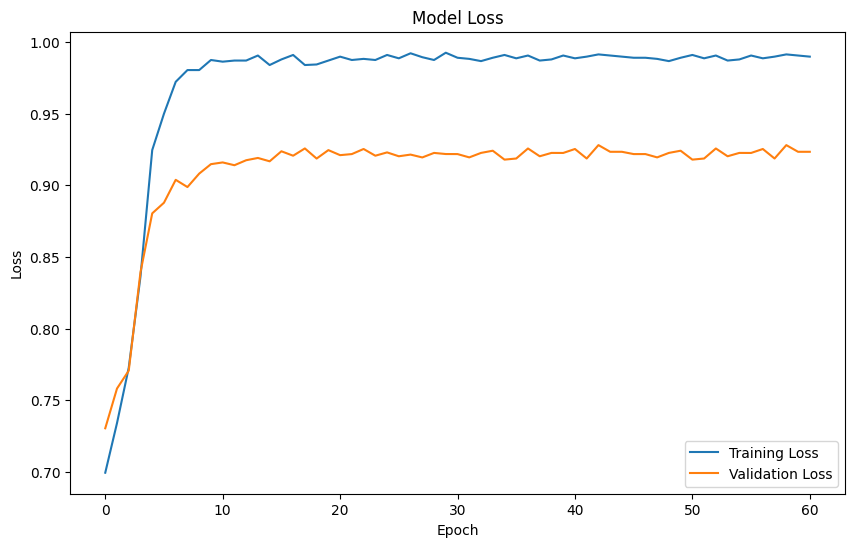

In [37]:
import matplotlib.pyplot as plt

loss_column = 'accuracy'
val_loss_column = 'val_accuracy'

plt.figure(figsize=(10, 6))

plt.plot(combined_df[loss_column], label='Training Loss')

if val_loss_column in combined_df.columns:
    plt.plot(combined_df[val_loss_column], label='Validation Loss')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Loss

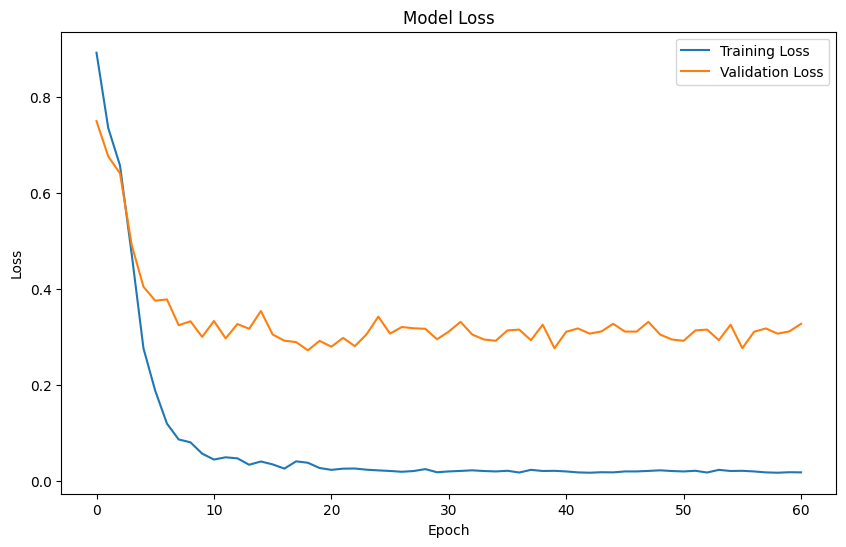

In [41]:
import matplotlib.pyplot as plt

loss_column = 'loss'
val_loss_column = 'val_loss'

plt.figure(figsize=(10, 6))

plt.plot(combined_df[loss_column], label='Training Loss')

if val_loss_column in combined_df.columns:
    plt.plot(combined_df[val_loss_column], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Precision

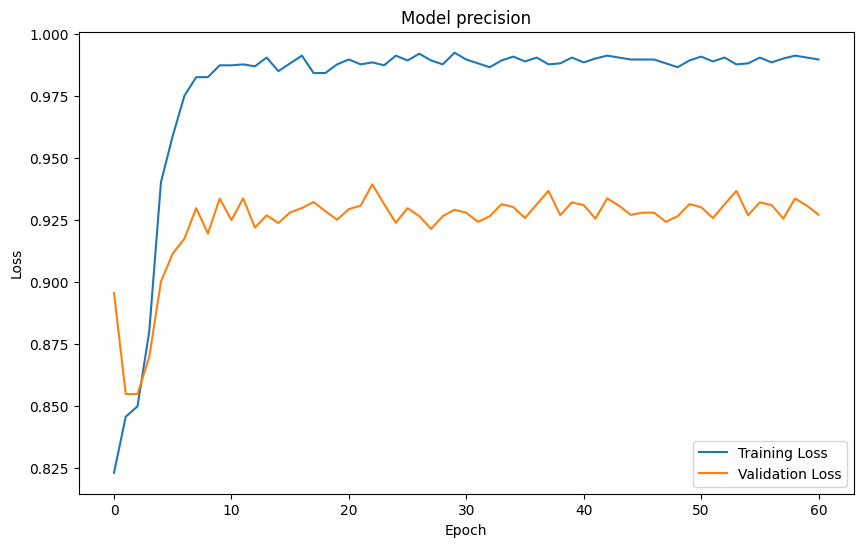

In [42]:
import matplotlib.pyplot as plt

loss_column = 'precision'
val_loss_column = 'val_precision'

plt.figure(figsize=(10, 6))

plt.plot(combined_df[loss_column], label='Training Loss')

if val_loss_column in combined_df.columns:
    plt.plot(combined_df[val_loss_column], label='Validation Loss')

plt.title('Model precision')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## AUC

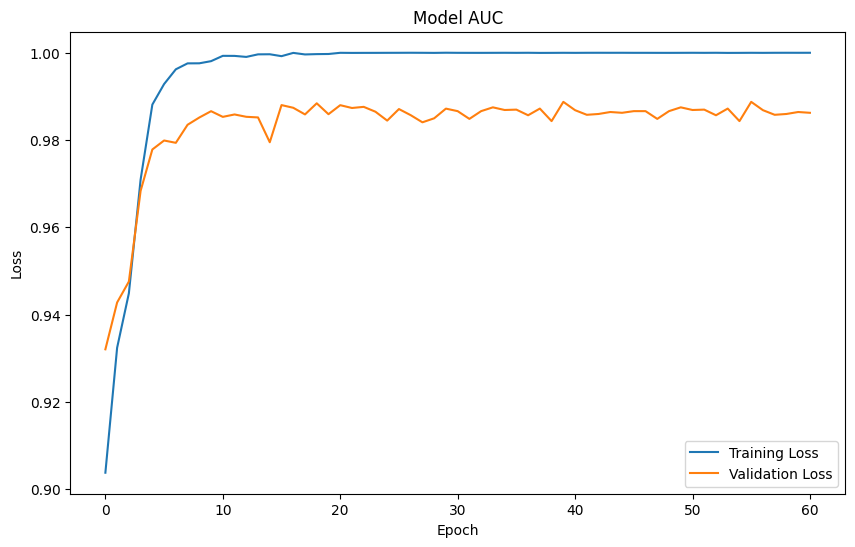

In [44]:
import matplotlib.pyplot as plt

loss_column = 'auc'
val_loss_column = 'val_auc'

plt.figure(figsize=(10, 6))

plt.plot(combined_df[loss_column], label='Training Loss')

if val_loss_column in combined_df.columns:
    plt.plot(combined_df[val_loss_column], label='Validation Loss')

plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Recall

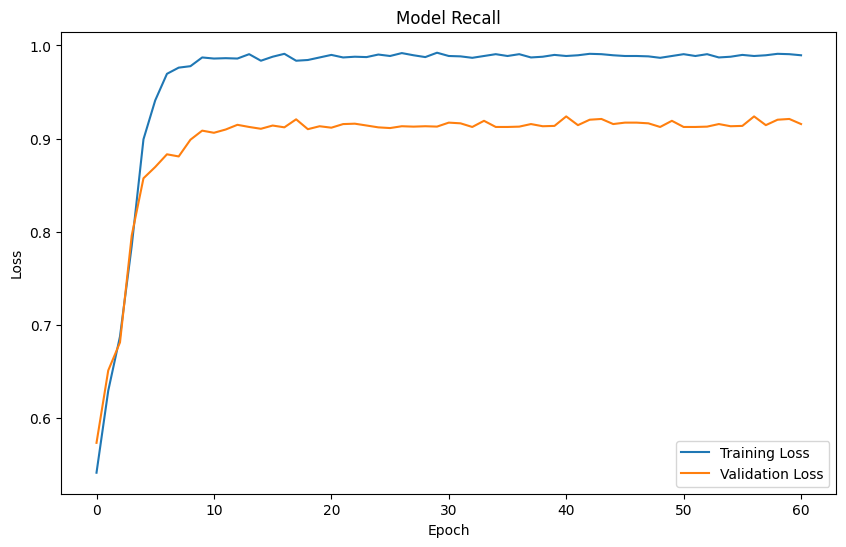

In [46]:
import matplotlib.pyplot as plt

loss_column = 'recall'
val_loss_column = 'val_recall'

plt.figure(figsize=(10, 6))

plt.plot(combined_df[loss_column], label='Training Loss')

if val_loss_column in combined_df.columns:
    plt.plot(combined_df[val_loss_column], label='Validation Loss')

plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Saving the Metrics

In [47]:
combined_df.to_csv('Metrics.csv', index=False)

In [38]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Preprocessed  model.keras


In [48]:
!zip -r metrics.zip Metrics.csv

  adding: Metrics.csv (deflated 70%)


In [49]:
from IPython.display import FileLink
FileLink('metrics.zip')

/kaggle/working/metrics.zip